## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128

50000/50000 [==============================] - 39s 785us/step - loss: 0.1881 - acc: 0.9471 - val_loss: 2.5171 - val_acc: 0.4652
Epoch 49/50
50000/50000 [==============================] - 39s 777us/step - loss: 0.1792 - acc: 0.9504 - val_loss: 2.4039 - val_acc: 0.4769
Epoch 50/50
50000/50000 [==============================] - 39s 775us/step - loss: 0.1754 - acc: 0.9518 - val_loss: 2.3994 - val_acc: 0.4753
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)      

50000/50000 [==============================] - 39s 782us/step - loss: 0.2254 - acc: 0.9353 - val_loss: 2.2905 - val_acc: 0.4670
Epoch 47/50
50000/50000 [==============================] - 39s 786us/step - loss: 0.2122 - acc: 0.9389 - val_loss: 2.3675 - val_acc: 0.4660
Epoch 48/50
50000/50000 [==============================] - 40s 797us/step - loss: 0.2044 - acc: 0.9424 - val_loss: 2.2977 - val_acc: 0.4716
Epoch 49/50
50000/50000 [==============================] - 39s 778us/step - loss: 0.1924 - acc: 0.9449 - val_loss: 2.3767 - val_acc: 0.4664
Epoch 50/50
50000/50000 [==============================] - 36s 724us/step - loss: 0.1815 - acc: 0.9506 - val_loss: 2.4472 - val_acc: 0.4588
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_laye

Epoch 44/50
50000/50000 [==============================] - 38s 767us/step - loss: 0.2353 - acc: 0.9316 - val_loss: 2.1933 - val_acc: 0.4825
Epoch 45/50
50000/50000 [==============================] - 38s 768us/step - loss: 0.2256 - acc: 0.9353 - val_loss: 2.2931 - val_acc: 0.4631
Epoch 46/50
50000/50000 [==============================] - 39s 778us/step - loss: 0.2181 - acc: 0.9366 - val_loss: 2.3850 - val_acc: 0.4782 loss: 0.2176 - acc:
Epoch 47/50
50000/50000 [==============================] - 39s 778us/step - loss: 0.2044 - acc: 0.9430 - val_loss: 2.3962 - val_acc: 0.4691
Epoch 48/50
50000/50000 [==============================] - 38s 769us/step - loss: 0.1935 - acc: 0.9466 - val_loss: 2.5041 - val_acc: 0.4584
Epoch 49/50
50000/50000 [==============================] - 39s 779us/step - loss: 0.1856 - acc: 0.9486 - val_loss: 2.5255 - val_acc: 0.4588
Epoch 50/50
50000/50000 [==============================] - 39s 780us/step - loss: 0.1737 - acc: 0.9524 - val_loss: 2.4497 - val_acc: 0.4735


50000/50000 [==============================] - 39s 778us/step - loss: 0.2853 - acc: 0.9128 - val_loss: 2.1837 - val_acc: 0.4687
Epoch 42/50
50000/50000 [==============================] - 39s 782us/step - loss: 0.2772 - acc: 0.9147 - val_loss: 2.2602 - val_acc: 0.4583
Epoch 43/50
50000/50000 [==============================] - 39s 778us/step - loss: 0.2633 - acc: 0.9195 - val_loss: 2.1757 - val_acc: 0.4729
Epoch 44/50
50000/50000 [==============================] - 39s 777us/step - loss: 0.2380 - acc: 0.9309 - val_loss: 2.2061 - val_acc: 0.4713
Epoch 45/50
50000/50000 [==============================] - 46s 919us/step - loss: 0.2380 - acc: 0.9299 - val_loss: 2.2864 - val_acc: 0.4698
Epoch 46/50
50000/50000 [==============================] - 47s 941us/step - loss: 0.2206 - acc: 0.9340 - val_loss: 2.3240 - val_acc: 0.4777
Epoch 47/50
50000/50000 [==============================] - 43s 858us/step - loss: 0.2099 - acc: 0.9397 - val_loss: 2.2610 - val_acc: 0.4830
Epoch 48/50
50000/50000 [=======

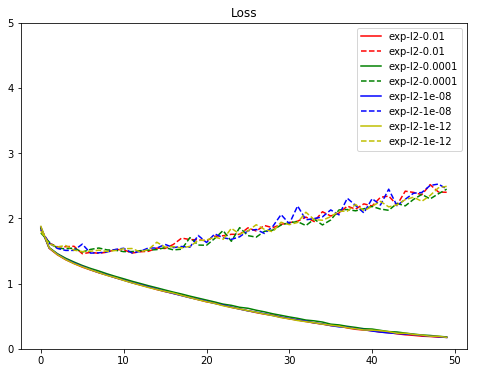

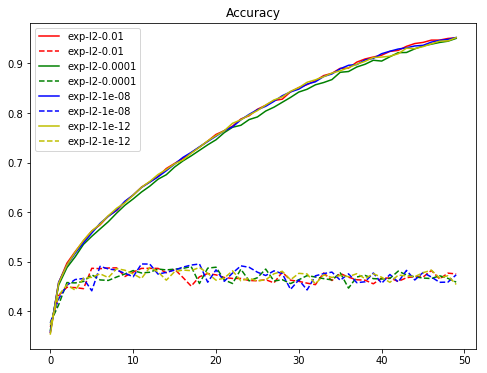

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()